# How a virtual hierarchy reduces memory footprint

A [virtual hierarchy](https://docs.activeviam.com/products/atoti/server/latest/docs/concepts/dimensions_and_hierarchies/#virtual-hierarchies) is a lightweight hierarchy implemented in [Atoti](https://www.atoti.io/). It offers a smaller memory footprint by not storing its members in the cube. This is especially handy for hierarchies with high cardinality, i.e. with many possible values. Usually, these are identifiers such as User ID, Shopping Cart ID, or Trade ID, where the hierarchy can have thousands of distinct values. These hierarchies are not typically the focus of interest for users in data analytics unless the specific use case requires a deep-dive investigation of such hierarchies.

Creating a virtual or "lightweight" hierarchy comes with some trade-offs in features:

* Navigation between the hierarchy members are not allowed. This means that it is not possible to use [`Lead`](https://learn.microsoft.com/en-us/sql/mdx/lead-mdx?view=sql-server-ver16) and [`Lag`](https://learn.microsoft.com/en-us/sql/mdx/lag-mdx?view=sql-server-ver16) functions such as [`atoti.shift`](https://docs.atoti.io/latest/lib/atoti/atoti.function.shift.html#atoti.shift) and [`atoti.date_shift`](https://docs.atoti.io/latest/lib/atoti/atoti.function.date_shift.html) on the virtual hierarchies.  
* The virtual hierarchy cannot be a [slicing hierarchy](https://docs.atoti.io/latest/api/atoti.Hierarchy.slicing.html#atoti.Hierarchy.slicing).
* For advanced users who manipulate the underlying MDX for querying, MDX expressions that includes a virtual hierarchy must include the `NON EMPTY` keyword. Member expressions must be written with the full member path: `[Dimension].[Hierarchy].[FirstLevel].[Path].[To].[My].[Member]`.  
* In the Atoti UI and the Atoti JupyterLab extension, when creating or editing a filter on a virtual hierarchy, the full list of members is not displayed. Rather, the user must use the searchbar to find members and filter on them.  

Let's explore more about virtual hierarchies in this notebook.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=virtual-hierarchies" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

## Setting up ClickHouse for Atoti DirectQuery

For this walkthrough, we will demonstrate a case where we have a hierarchy with high cardinality, and use [Atoti DirectQuery](https://docs.atoti.io/latest/how_tos/use_directquery.html) to connect to a ClickHouse instance that hosts more than 700k trade records.

⚠️ We require a valid license to [unlock all Atoti features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html) and to be able to use DirectQuery. You can register online for an [evaluation license](https://atoti.io/evaluation-license-request/). In addition, ClickHouse provides a 30-day trial for its [cloud-based DBMS](https://clickhouse.com/cloud).  

Let's first set up our database by creating a service and running the following [clickhouse_table_user.sql](./clickhouse_table_user.sql) script.

### Creating DB, Tables, and Roles  

We can navigate to our query editor for one of our Clickhouse instances and run the following SQL commands from [clickhouse_table_user.sql](./clickhouse_table_user.sql):

![setting-up-db](https://data.atoti.io/notebooks/virtual-hierarchies/img/setting-up-db.png)

Here, we create the `ATOTI` database.

```sql
CREATE DATABASE IF NOT EXISTS ATOTI;
```

Next, we create the `TRADE_PNLS` table.

```sql
CREATE TABLE IF NOT EXISTS ATOTI.TRADE_PNLS (
  `BookId` Int64, 
  `AsOfDate` Date32, 
  `TradeId` String, 
  `DataSet` String, 
  `RiskFactor` String, 
  `RiskClass` String, 
  `SensitivityName` String, 
  `ccy` String, 
  `pnl_vector` Array(Float64), 
)
ENGINE = MergeTree()
PRIMARY KEY (`BookId`, `AsOfDate`, `TradeId`, `DataSet`);
```

And finally, we grant the specific privileges for the `querier` role, which will be the role assigned to any user connecting to the ClickHouse instance using Atoti DirectQuery. In this case, we create a user `ATOTI_QUERIER` and specify the password as `Password123!`.

```sql
CREATE ROLE querier;

GRANT SELECT ON ATOTI.* TO querier WITH GRANT OPTION;
GRANT SELECT ON system.databases TO querier WITH GRANT OPTION;
GRANT SELECT ON system.processes TO querier WITH GRANT OPTION;
GRANT SELECT ON system.tables TO querier WITH GRANT OPTION;
GRANT SELECT ON system.columns TO querier WITH GRANT OPTION;

CREATE USER IF NOT EXISTS ATOTI_QUERIER IDENTIFIED WITH sha256_password BY 'Password123!' DEFAULT ROLE querier;
```

### Loading Data into ClickHouse

Now let's load data within the `TRADE_PNLS` table that we just created. Download the following `.zip` file:

* [trades_pnl.zip](https://data.atoti.io/notebooks/direct-query/data/trades_pnl.zip)

and extract the CSV from within the `.zip` file to upload the CSV to the ClickHouse instance using the [ClickHouse Command-Line Client (CLI)](https://clickhouse.com/docs/en/install). For Windows users, first install WLS 2 by running the command `wsl --install` in PowerShell before installing [ClickHouse CLI](https://clickhouse.com/docs/en/integrations/sql-clients/clickhouse-client-local).  

To do this, we'll also need to set up the following environment variables. 

💡 **Note:** We set up our environment variables as a DBMS user.

```bash
export CLICKHOUSE_HOST=<host>
export CLICKHOUSE_USER=<db_user>
export CLICKHOUSE_PASSWORD=<db_password>
export CLICKHOUSE_DB=<db>
export TRADE_PNL_FILEPATH=<filepath_to_csv>
```

We can also verify our credentials by clicking the *Connect* button.

![find-hostname](https://data.atoti.io/notebooks/virtual-hierarchies/img/find-hostname.png)

Once we've set our environment variables, we can execute the following to upload the CSV and load the `TRADE_PNLS` table:

```bash
clickhouse client --host "$CLICKHOUSE_HOST" --secure --password  "$CLICKHOUSE_PASSWORD" --database "$CLICKHOUSE_DB" --query="INSERT INTO TRADE_PNLS FORMAT CSV" < "$TRADE_PNL_FILEPATH"
```

For this walkthrough, we executed the following sequence:

```bash
export CLICKHOUSE_HOST=jelt586y67.us-east1.gcp.clickhouse.cloud
export CLICKHOUSE_USER=default
export CLICKHOUSE_PASSWORD=5A2_wByjrMBxz
export CLICKHOUSE_DB=ATOTI
export TRADE_PNL_FILEPATH=~/Downloads/trades_pnl.csv
```

```bash
clickhouse client --host jelt586y67.us-east1.gcp.clickhouse.cloud --secure --password '5A2_wByjrMBxz' --database "ATOTI" --query="INSERT INTO TRADE_PNLS FORMAT CSV" < ~/Downloads/trades_pnl.csv
``` 

For Windows users, remember to copy the unzipped datafile to the Ubuntu directory:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/ubuntu_folder.png" width="750px"/>

## Using Atoti DirectQuery 

Now that we have our ClickHouse instance set up and ready-to-go, let's set up our Atoti cube.

### Set up Atoti cube

Uncomment the following cell to install the [DirectQuery plugin](https://docs.atoti.io/latest/reference.html#directquery) if you haven't installed it yet.

In [1]:
# !pip install atoti_directquery_clickhouse

Now let's import the required libraries and instantiate the Atoti session.

In [2]:
import os
import atoti as tt
from atoti_directquery_clickhouse import (
    ClickhouseConnectionInfo,
    ClickhouseTableOptions,
)

In [3]:
session = tt.Session()

Next, we'll make the connection to the ClickHouse instance using [connect_to_external_database](https://docs.atoti.io/latest/api/atoti.Session.connect_to_external_database.html#atoti.Session.connect_to_external_database). 

Before we do this, we should make sure we set our environment variables to use the `ATOTI_QUERIER` user assigned with the `querier` role that we created in previous steps.

```bash
export CLICKHOUSE_HOST=<host>
export CLICKHOUSE_PORT=8443
export CLICKHOUSE_USER=ATOTI_QUERIER
export CLICKHOUSE_PASSWORD=Password123!
```

💡 **Note:** In the below code snippet, we configure the password in a separate parameter instead of embedding it in the URL. This is a good practice to prevent the password from getting logged along with the URL. Furthermore, the ClickHouse password requires at least 1 special character, and special characters can cause problems in URLs. 

In [5]:
connection_info = ClickhouseConnectionInfo(
    f"clickhouse:https://{os.environ['CLICKHOUSE_USER']}@{os.environ['CLICKHOUSE_HOST']}:{os.environ['CLICKHOUSE_PORT']}",
    password=os.environ["CLICKHOUSE_PASSWORD"],
)

db = session.connect_to_external_database(connection_info)

Under the `ATOTI` database in ClickHouse, we have two tables. We'll use only the `TRADE_PNLS` table.

In [6]:
db.tables

In [7]:
trades_atoti = session.add_external_table(
    db.tables["TRADE_PNLS"],
    table_name="Trade PnL",
    options=ClickhouseTableOptions(keys=["AsOfDate", "TradeId", "BookId", "DataSet"]),
)

In [8]:
print(f"# of records: {len(trades_atoti)}, # of columns: {len(trades_atoti.columns)}")

# of records: 765754, # of columns: 9


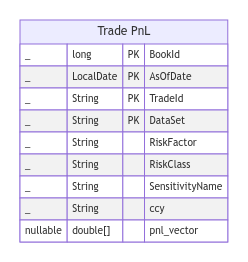

In [9]:
cube = session.create_cube(trades_atoti)
session.tables.schema

Before proceeding further, let's do some simple configurations that will help avoid querying the entire database. We set the `AsOfDate` as a slicing hierarchy and sort it in descending order. This way, only data from the latest `AsOfDate` will be returned by default when we query Atoti.  

In [10]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [11]:
h["AsOfDate"].slicing = True
l["AsOfDate"].order = tt.NaturalOrder(ascending=False)

Atoti is now able to retrieve data from ClickHouse without storing them in-memory.  

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
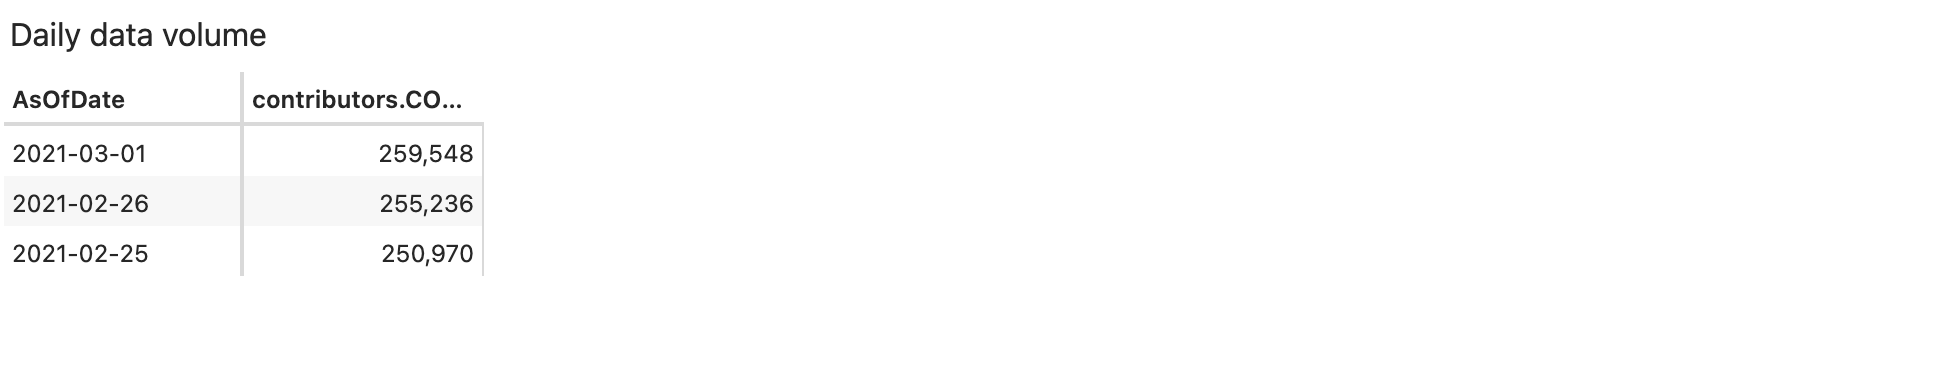

In [12]:
session.widget

### Cardinality Investigation

Some of our hierarchies have a high cardinality (= number of distinct values). Let's create some measures to visualize that.

In [13]:
m["Distinct Trade Id"] = tt.agg.count_distinct(trades_atoti["TradeId"])
m["Distinct BookId"] = tt.agg.count_distinct(trades_atoti["BookId"])
m["Distinct RiskFactor"] = tt.agg.count_distinct(trades_atoti["RiskFactor"])
m["Distinct RiskClass"] = tt.agg.count_distinct(trades_atoti["RiskClass"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
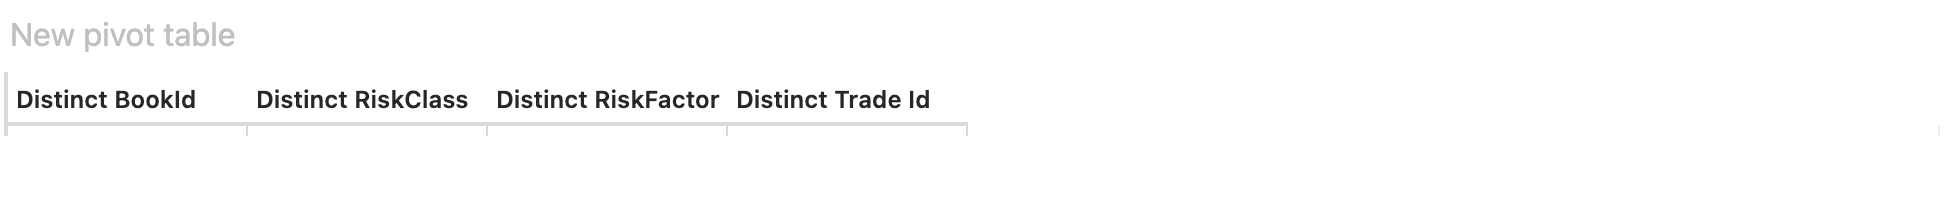

In [14]:
session.widget

We can see that `TradeId` has far more unique values than the other hierarchies. Iterating through the hierarchies, we can see that only `TradeId` is set as a virtual hierarchy by the application.

In [15]:
for _hierarchy in h:
    print(f"Hierarchy name: {_hierarchy}: {h[_hierarchy].virtual}")

Hierarchy name: ('Trade PnL', 'RiskFactor'): False
Hierarchy name: ('Trade PnL', 'AsOfDate'): False
Hierarchy name: ('Trade PnL', 'ccy'): False
Hierarchy name: ('Trade PnL', 'BookId'): False
Hierarchy name: ('Trade PnL', 'RiskClass'): False
Hierarchy name: ('Trade PnL', 'DataSet'): False
Hierarchy name: ('Trade PnL', 'SensitivityName'): False
Hierarchy name: ('Trade PnL', 'TradeId'): True


⚠️ It is important to know that **with the use of DirectQuery, a hierarchy is automatically set as virtual if its cardinality is greater than or equal to 10000**. Without DirectQuery, we have to explicitly set a hierarchy as virtual where necessary.

### Trade-off on interactive filtering

Normally, when creating or editing filters on a visualization using Atoti UI or the Atoti JupyterLab extension, the popover displays the full list of members of the selected hierarchy:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/normal_hierarchy_filter.gif" width="75%"/>  

For virtual hierarchies, while the members are not retrieved by default, we can search on demand:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/filter-on-demand.gif" width="75%" />  

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
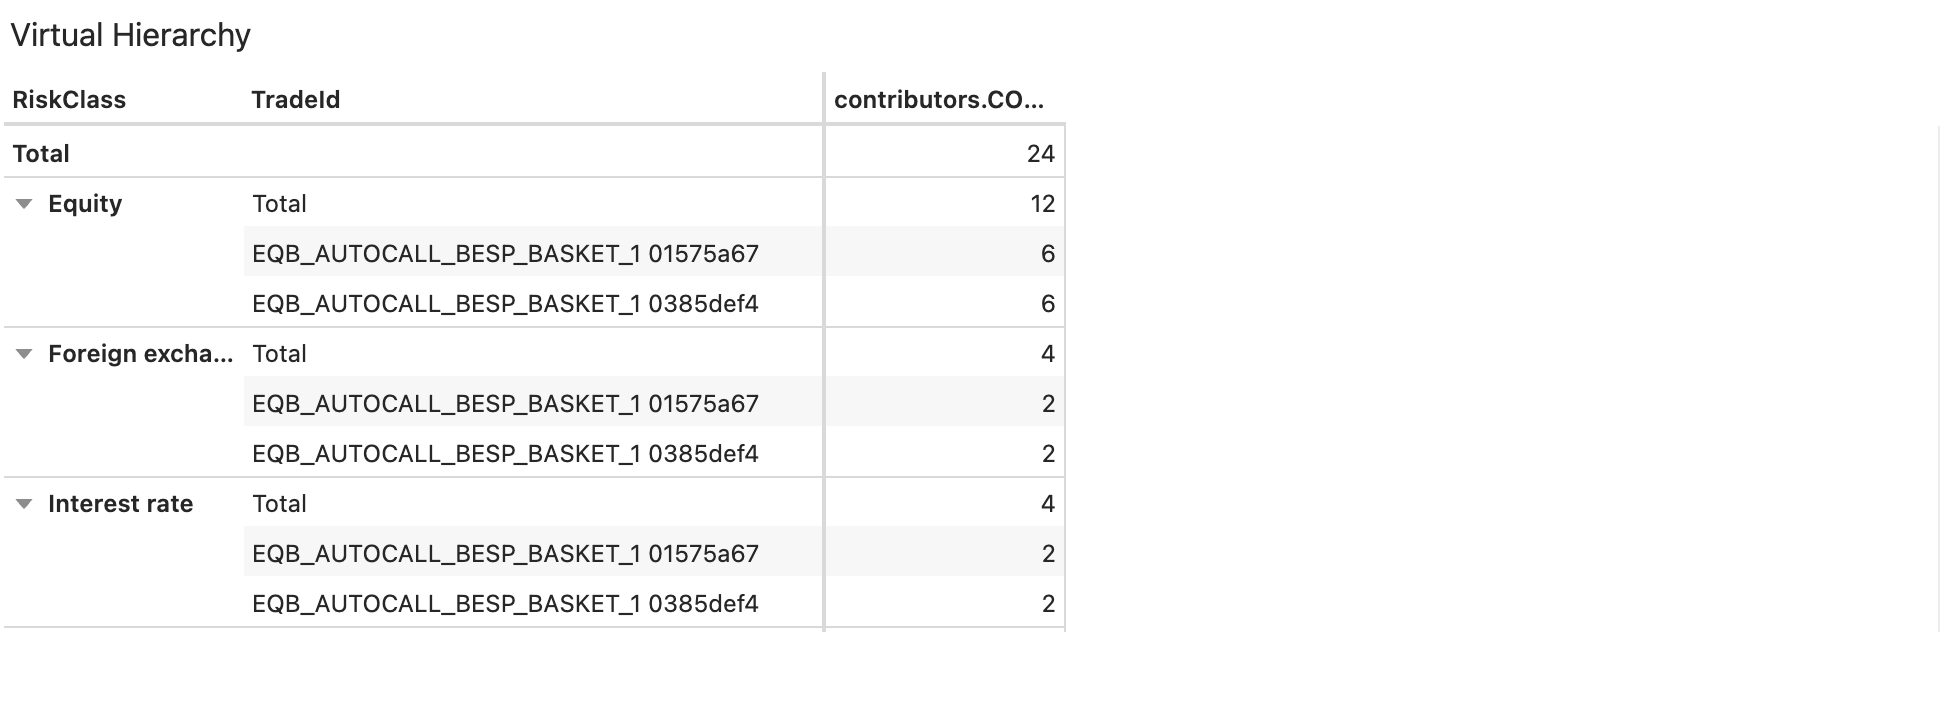

In [16]:
session.widget

### MDX with Non Empty for a virtual hierarchy 

In [Multidimensional Expressions (MDX)](https://learn.microsoft.com/en-us/analysis-services/multidimensional-models/mdx/mdx-query-the-basic-query?view=asallproducts-allversions), the keyword [`Non Empty`](https://learn.microsoft.com/en-us/sql/mdx/nonempty-mdx?view=sql-server-ver16) is used to filter out empty cells from the result set of a query.

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/mdx.png"/>  

We can inspect the generated MDX of a visualization by expanding on the Property Inspector of JupyterLab for its cell.    

MDX expressions including a virtual hierarchy must include the `NON EMPTY` keyword. Let's see what happens when we remove it for the rows containing our `TradeId` from the MDX above: 

In [17]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

### Memory footprint difference between virtual and non-virtual hierarchies

From the [server log](https://docs.atoti.io/latest/lib/atoti/atoti.config.logging_config.html#atoti.LoggingConfig) (found under `$HOME/.atoti` folder by default), we can see that we have only utilized `140KB` of direct memory and less than `100 MB` of heap so far:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/virtual_hierarchy_mem_usage.png" />  

Let's try changing the `TradeId` into a non-virtual hierarchy.

In [18]:
h["TradeId"].virtual = False

After setting the `virtual` parameter to `False` for the `TradeId` hierarchy, the memory usage increases — now we utilize more than 1 MB of direct memory. 
  
<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/non-virtual_hierarchy_mem_usage.png" />

We can see that setting a hierarchy as virtual makes it lightweight memory-wise, while still being queryable by users, just in a slightly more restrictive way.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=virtual-hierarchies" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>